# Python: Sample Selection Models

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the average treatment effect (ATE) under sample selection or outcome attrition. The estimation is based on a simulated DGP from Appendix E of [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071).  

Consider the following DGP:
$$
\begin{align*}
Y_i &= \theta_0 D_i + X_i'\beta_0 + \varepsilon_i,\\
S_i &= \mathbb{1}\{D_i + \gamma_0 Z_i + X_i'\beta_0 + \upsilon_i > 0\}, \\
D_i &= \mathbb{1}\{X_i'\beta_0 + \xi_i > 0\}
\end{align*}
$$
where $Y_i$ is observed if $S_i=1$
with
$$X_i \sim N(0, \sigma^2_X), \quad Z_i \sim N(0, 1), \quad (\varepsilon,_i \nu_i) \sim N(0, \sigma^2_{\varepsilon, \nu}), \quad \xi_i \sim N(0, 1).$$

Let $D_i\in\{0,1\}$ denote the treatment status of unit $i$ and let $Y_{i}$ be the outcome of interest of unit $i$.
Using the potential outcome notation, we can write $Y_{i}(d)$ for the potential outcome of unit $i$ and treatment status $d$. Further, let $X_i$ denote a vector of pre-treatment covariates.  

## Outcome missing at random (MAR)  
Now consider the first setting, in which the outcomes are missing at random (MAR), according to assumptions in [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071). 
Let the covariance matrix $\sigma^2_X$ be such that $a_{ij} = 0.5^{|i - j|}$, $\gamma_0 = 0$, $\sigma^2_{\varepsilon, \upsilon} = \begin{pmatrix} 1 & 0 \\  0 & 1 \end{pmatrix}$ and finally, let the vector of coefficients $\beta_0$ resemble a quadratic decay of coefficients importance; $\beta_{0,j} = 0.4/j^2$ for $j = 1, \ldots, p$. 


### Data

We will use the implemented data generating process `make_ssm_data` to generate data according to the simulation in Appendix E of [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071). The true ATE in this DGP is equal to $\theta_0=1$ (it can be changed by setting the parameter `theta`). 

The data generating process `make_ssm_data` by default settings already returns a `DoubleMLData` object (however, it can return a pandas DataFrame or a NumPy array if `return_type` is specified accordingly). In this first setting, we are estimating the ATE under missingness at random, so we set `mar=True`.
The selection indicator `S` can be set via `s_col`.

In [1]:
import numpy as np
from doubleml.irm.datasets import make_ssm_data
import doubleml as dml

np.random.seed(42)
n_obs = 2000
df = make_ssm_data(n_obs=n_obs, mar=True, return_type='DataFrame')

dml_data = dml.DoubleMLSSMData(df, 'y', 'd', s_col='s')
print(dml_data)

================== DoubleMLSSMData Object ==================
Selection variable: s
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100']
Instrument variable(s): None
No. Observations: 2000




### Estimation

To estimate the ATE under sample selection, we will use the `DoubleMLSSM` class. 

As for all `DoubleML` classes, we have to specify learners, which have to be initialized first.
Given the simulated quadratic decay of coefficients importance, Lasso regression should be a suitable option (as for propensity scores, this will be a $\mathcal{l}_1$-penalized Logistic Regression). 

The learner `ml_g` is used to fit conditional expectations of the outcome $\mathbb{E}[Y_i|D_i, S_i, X_i]$, whereas the learners `ml_m` and `ml_pi` will be used to estimate the treatment and selection propensity scores $P(D_i=1|X_i)$ and $P(S_i=1|D_i, X_i)$.

In [2]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV

ml_g = LassoCV()
ml_m = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_pi = LogisticRegressionCV(penalty='l1', solver='liblinear')

The `DoubleMLSSM` class can be used as any other `DoubleML` class. 

The score is set to `score='missing-at-random'`, since the parameters of the DGP were set to satisfy the assumptions of outcomes missing at random. Further, since the simulation in [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071) uses normalization of inverse probability weights, we will apply the same setting by `normalize_ipw=True`.

After initialization, we have to call the `fit()` method to estimate the nuisance elements.

In [3]:
dml_ssm = dml.DoubleMLSSM(dml_data, ml_g, ml_m, ml_pi, score='missing-at-random', normalize_ipw=True)
dml_ssm.fit()

print(dml_ssm)

================== DoubleMLSSM Object ==================

------------------ Data Summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100']
Instrument variable(s): None
No. Observations: 2000


------------------ Score & Algorithm ------------------
Score function: missin

Confidence intervals at different levels can be obtained via

In [4]:
print(dml_ssm.confint(level=0.90))

     5.0 %    95.0 %
d  0.94629  1.048699


### ATE estimates distribution

Here, we add a small simulation where we generate multiple datasets, estimate the ATE and collect the results (this may take some time). 

In [5]:
n_rep = 200
ATE = 1.0

ATE_estimates = np.full((n_rep), np.nan)

np.random.seed(42)
for i_rep in range(n_rep):
    if (i_rep % int(n_rep/10)) == 0:
        print(f'Iteration: {i_rep}/{n_rep}')
    dml_data = make_ssm_data(n_obs=n_obs, mar=True)
    dml_ssm = dml.DoubleMLSSM(dml_data, ml_g, ml_m, ml_pi, score='missing-at-random', normalize_ipw=True)
    dml_ssm.fit()

    ATE_estimates[i_rep] = dml_ssm.coef.squeeze()

Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200


The distribution of the estimates takes the following form

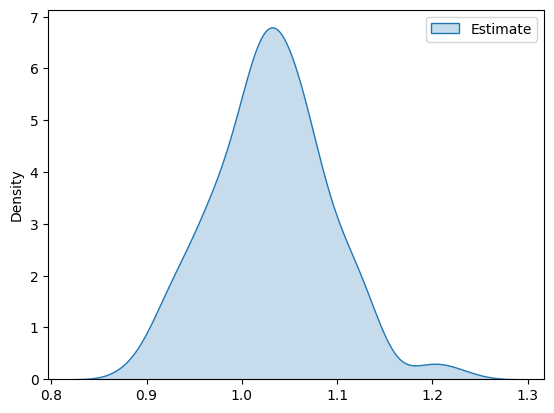

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_pa = pd.DataFrame(ATE_estimates, columns=['Estimate'])
g = sns.kdeplot(df_pa, fill=True)
plt.show()

## Outcome missing under nonignorable nonresponse
Now consider a different setting, in which the outcomes are missing under nonignorable nonresponse assumptions in [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071). 
Let the covariance matrix $\sigma^2_X$ again be such that $a_{ij} = 0.5^{|i - j|}$, but now $\gamma_0 = 1$ and $\sigma^2_{\varepsilon, \upsilon} = \begin{pmatrix} 1 & 0.8 \\  0.8 & 1 \end{pmatrix}$ to show a strong correlation between $\varepsilon$ and $\upsilon$. Let the vector of coefficients $\beta$ again resemble a quadratic decay of coefficients importance; $\beta_{0,j} = 0.4/j^2$ for $j = 1, \ldots, p$.

The directed acyclic graph (DAG) shows the the structure of the causal model.

<p align="center">
  <img src="figures/py_ssm.svg" alt="Graph">
</p>

### Data

We will again use the implemented data generating process `make_ssm_data` to generate data according to the simulation in Appendix E of [Bia, Huber and Lafférs (2023)](https://doi.org/10.1080/07350015.2023.2271071). We will again leave the default ATE equal to $\theta_0=1$.

In this setting, we are estimating the ATE under nonignorable nonresponse, so we set `mar=False`. Again, the selection indicator `S` can be set via `s_col`. Further, we need to specify an intrument via `z_col`.

In [7]:
np.random.seed(42)
n_obs = 8000
df = make_ssm_data(n_obs=n_obs, mar=False, return_type='DataFrame')
dml_data = dml.DoubleMLSSMData(df, 'y', 'd', z_cols='z', s_col='s')
print(dml_data)

================== DoubleMLSSMData Object ==================
Selection variable: s
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100']
Instrument variable(s): ['z']
No. Observations: 8000




### Estimation

We will again use the `DoubleMLSSM` class. 

Further,  will leave he learners for all nuisance functions to be the same as in the first setting, as the simulated quadratic decay of coefficients importance still holds.

Now the learner `ml_g` is used to fit conditional expectations of the outcome $\mathbb{E}[Y_i|D_i, S_i, X_i, \Pi_i]$, whereas the learners `ml_m` and `ml_pi` will be used to estimate the treatment and selection propensity scores $P(D_i=1|X_i, \Pi_i)$ and $P(S_i=1|D_i, X_i, Z_i)$.

In [8]:
ml_g = LassoCV()
ml_m = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_pi = LogisticRegressionCV(penalty='l1', solver='liblinear')

The score is now set to `'nonignorable'`, since the parameters of the DGP were set to satisfy the assumptions of outcomes missing under nonignorable nonresponse.

In [9]:
np.random.seed(42)
dml_ssm = dml.DoubleMLSSM(dml_data, ml_g, ml_m, ml_pi, score='nonignorable')
dml_ssm.fit()

print(dml_ssm)

================== DoubleMLSSM Object ==================

------------------ Data Summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100']
Instrument variable(s): ['z']
No. Observations: 8000


------------------ Score & Algorithm ------------------
Score function: nonig

### ATE estimates distribution

Here we again add a small simulation where we generate multiple datasets, estimate the ATE and collect the results (this may take some time). 

In [10]:
ml_g = LassoCV()
ml_m = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_pi = LogisticRegressionCV(penalty='l1', solver='liblinear')


n_rep = 200
ATE = 1.0

ATE_estimates = np.full((n_rep), np.nan)

np.random.seed(42)
for i_rep in range(n_rep):
    if (i_rep % int(n_rep/10)) == 0:
        print(f'Iteration: {i_rep}/{n_rep}')
    dml_data = make_ssm_data(n_obs=n_obs, mar=False)
    dml_ssm = dml.DoubleMLSSM(dml_data, ml_g, ml_m, ml_pi, score='nonignorable')
    dml_ssm.fit()

    ATE_estimates[i_rep] = dml_ssm.coef.squeeze()

Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200


And plot the estimates distribution

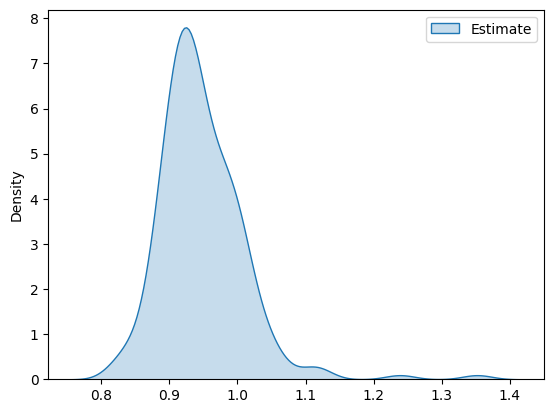

In [11]:
df_pa = pd.DataFrame(ATE_estimates, columns=['Estimate'])
g = sns.kdeplot(df_pa, fill=True)
plt.show()